## Set Up
Import packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from keras import models
from keras import layers
from keras import initializers
from keras import backend as k

## Data generation

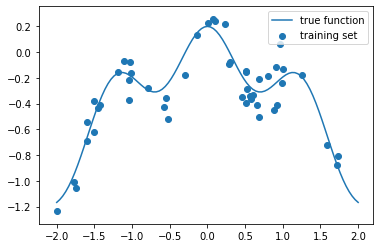

In [6]:
# set seed for reproducibility
np.random.seed(1)

def true_f_ex1(x, a, b):
  return(a*np.cos(5*x) + b*np.square(x))

def sim_data_ex1(n, a, b, sd, seed):
  '''
  A function to randomly generate data with a linear decision boundary
  
  Arguments:
   - n: integer sample size
  
  Return:
   - (x, y) tuple.  x is a numpy array of shape (n, 2) with feature values;
     y is a numpy array of shape (n, 1) with responses (0 or 1)
  '''
  np.random.seed(seed)

  # generate x, n by 1 matrix with observations in rows
  x = 4 * np.random.random((n, 1)) - 2

  # generate y
  y = true_f_ex1(x, a, b) + np.random.standard_normal((n, 1)) * sd

  return((x, y))

# generate training data and plot it
a = 0.2
b = -0.25
sd = 0.15
train_x, train_y = sim_data_ex1(n = 50, a = a, b = b, sd = sd, seed = 986)
val_x, val_y = sim_data_ex1(n = 10000, a = a, b = b, sd = sd, seed = 6315)

# true_function_values
x_grid = np.linspace(-2.0, 2.0, num = 101)
x_grid = x_grid.reshape(1, x_grid.shape[0])
true_f = true_f_ex1(x_grid[0, :], a, b)

# make a plot
plt.plot(x_grid[0, :], true_f, label = "true function")
plt.scatter(train_x[:, 0], train_y[:, 0], label = "training set")
plt.legend(loc = "upper right")
plt.show()

## Utility functions

First function fits a neural network model with specified number of layers and units, relu activations in all hidden layers, and an output layer with one unit and linear activation

Second function plots the activation outputs of all units, by layer.

In [0]:
from keras import backend as K

def draw_neural_net(ax, left, right, bottom, top, layer_sizes, dropout_units):
    '''
    Draw a neural network cartoon using matplotilb.
    Adapted from https://gist.github.com/craffel/2d727968c3aaebd10359
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
        - dropout_units: list of list of int
            list of length = number of layers.  Each component is a list of ints
            giving units that are dropped out.
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            if m in dropout_units[n]:
                circle_color = 'gray'
            else: 
                circle_color = 'w'
            
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color=circle_color, ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b, dropout_units_a, dropout_units_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:], dropout_units[:-1], dropout_units[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                if m not in dropout_units_a and o not in dropout_units_b:
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                      [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                    ax.add_artist(line)

# this code is very specific to my plotting function, don't worry about it.
# also, never write code this unreadable ;)
def sample_dropout(layer_sizes, dropout_rate):
  sampled = [np.where(np.random.binomial(n = 1, p = dropout_rate, size = (layer_size,)))[0].tolist() \
      for layer_size in layer_sizes[0:(len(layer_sizes)-1)]]
  
  if sampled[0] == [0,1,2,3]:
    sampled[0] = []
      
  return(sampled + [[]])

def fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds, num_epochs = 1000, return_history = False):
  model = models.Sequential()

  # add hidden layers
  input_units = [1] + hidden_units
  for (num_units, input_units, b_init_seed, w_init_seed) in zip(hidden_units, input_units, b_init_seeds, w_init_seeds):
    b_initializer = initializers.RandomNormal(seed=b_init_seed)
    w_initializer = initializers.RandomNormal(seed=w_init_seed)
    model.add(layers.Dense(num_units,
        activation = 'relu',
        input_shape = (input_units,),
        bias_initializer = b_initializer,
        kernel_initializer = w_initializer))
  
  # add output layer
  b_initializer = initializers.RandomNormal(seed=b_init_seeds[-1])
  w_initializer = initializers.RandomNormal(seed=w_init_seeds[-1])
  model.add(layers.Dense(1,
      activation = 'linear',
      bias_initializer = b_initializer,
      kernel_initializer = w_initializer))

  # compile and fit model
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
  if return_history:
    history = model.fit(train_x, train_y,
      validation_data = (val_x, val_y),
      epochs = num_epochs,
      batch_size = train_x.shape[0],
      verbose = 0)
    
    return(model, history)
  else:
    history = model.fit(train_x, train_y,
      epochs = num_epochs,
      batch_size = train_x.shape[0],
      verbose = 0)
    
    return(model)



def plot_layers(model, hidden_legend, include_hidden = True, figsize=(10, 8)):
  if include_hidden:
    num_model_layers = len(model.layers)
  else:
    num_model_layers = 1
  
  fig, axs = plt.subplots(num_model_layers, 1, figsize=figsize)

  # Hidden layers
  if include_hidden:
    for i in range(num_model_layers - 1):
      get_layer_a = K.function([model.layers[0].input], [model.layers[i].output])
      a = get_layer_a([x_grid.T])[0].T

      (w, b) = model.layers[i].get_weights()
      b = b.reshape(b.shape[0], 1)

      for j in range(b.shape[0]):
        axs[i].plot(x_grid[0, :], a[j, :], label = "a" + str(j+1))
      
      if hidden_legend:
        axs[i].legend(ncol = 5)
      
    last_ax = axs[-1]
  else:
    last_ax = axs
  
  # Output layer
  a_output = model.predict(x_grid.T)

  last_ax.plot(x_grid[0, :], true_f, label = "true function")
  last_ax.plot(x_grid[0, :], a_output, label = "estimated function")
  last_ax.scatter(train_x[:, 0], train_y[:, 0], label = "training set")

  plt.show()



def plot_layer_activations_facetted(model, layer_to_plot):
  fig, axs = plt.subplots(16, 2, figsize=(16, 24))

  # Last hidden layer activations, split up
  get_layer_a = K.function([model.layers[0].input], [model.layers[layer_to_plot].output])
  (w, b) = model.layers[layer_to_plot].get_weights()
  b = b.reshape(b.shape[0], 1)

  a = get_layer_a([x_grid.T])[0].T

  #print("a shape = " + str(a.shape))
  eps = 0.025

  for i in range(32):
    plot_row = i % 16
    plot_col = i // 16
    for j in range(16):
      axs[plot_row, plot_col].plot(x_grid[0, :], a[j + i*16, :], label = "a" + str(j+i*32+1))

      axs[plot_row, plot_col].vlines([0.8816905+eps], 0., 0.5, colors='red')
      axs[plot_row, plot_col].vlines([0.8816905-eps], 0., 0.5, colors='red')
      axs[plot_row, plot_col].vlines([-0.52717707+eps], 0., 0.5, colors='red')
      axs[plot_row, plot_col].vlines([-0.52717707-eps], 0., 0.5, colors='red')
  #plt.legend()
  plt.show()



def plot_decision_boundary(model_fit, preprocess_x_fn, x1lim, x2lim, gridlen, train_x, train_y):
    '''
    Plot decision boundaries for a Keras model fit with 2 quantitative inputs
    
    Arugments:
     - model_fit: keras model fit
     - preprocess_x_fn: function to preprocess x
     - x1lim: tuple of lower and upper limits for x1
     - x2lim: tuple of lower and upper limits for x2
     - gridlen: how many values of x1 and x2 for which to obtain predictions
     - train_x: n by 2 array of x values for training set
     - train_y: n by 1 array of y values for training set
    '''
    dx1 = (x1lim[1] - x1lim[0])/gridlen
    dx2 = (x2lim[1] - x2lim[0])/gridlen
    background_x0, background_x1 = np.mgrid[slice(x1lim[0], x1lim[1] + dx1, dx1), slice(x2lim[0], x2lim[1] + dx2, dx2)]
    background_x0_long = background_x0[0:gridlen,0:gridlen].reshape((gridlen**2, 1))
    background_x1_long = background_x1[0:gridlen,0:gridlen].reshape((gridlen**2, 1))
    background_x = np.concatenate((background_x0_long, background_x1_long), axis = 1)
    if preprocess_x_fn is not None:
        background_x = preprocess_x_fn(background_x)
    
    yhat_long = (model_fit.predict(background_x) > 0.5)
    yhat = yhat_long.reshape((gridlen, gridlen))

    fig, ax = plt.subplots()
    im = ax.pcolormesh(background_x0, background_x1, yhat, norm = plt.Normalize(-0.2, 1.2), cmap = plt.get_cmap('plasma'), alpha = 0.2, edgecolors = 'none', antialiased = True)
    im = ax.scatter(train_x[:, 0], train_x[:, 1], c = train_y[:, 0], norm = plt.Normalize(-0.2, 1.2), cmap = plt.get_cmap('plasma'))
    plt.show()

## Model with so many hidden layers and units


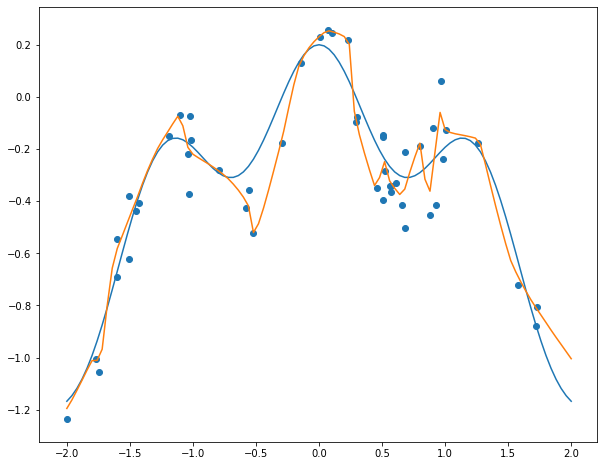

In [11]:
hidden_units = [512, 512, 512, 512, 512]
np.random.seed(65392)
b_init_seeds = np.random.randint(1, 1e6, size = len(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = len(hidden_units)+1)
model_somany = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds, return_history = False)
plot_layers(model_somany, hidden_legend=False, include_hidden = False)

## Three ideas to fix:
### Idea 1: smaller models -- let's try fewer units per layer

Why?  The bigger your model, the more flexibility/capacity to overfit.

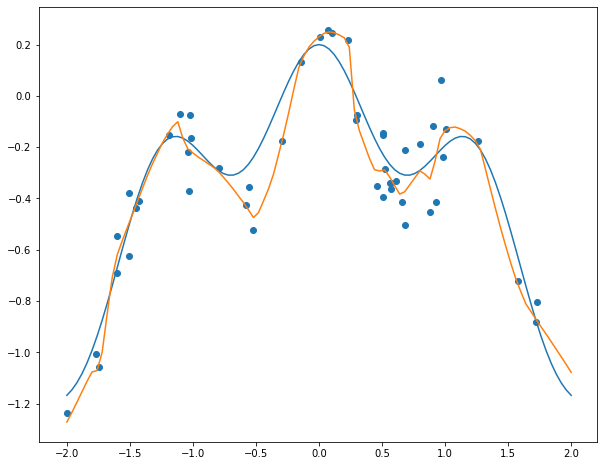

In [10]:
hidden_units = [256, 256, 256, 256, 256]
np.random.seed(65392)
b_init_seeds = np.random.randint(1, 1e6, size = len(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = len(hidden_units)+1)
(model_256, history_256) = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds, num_epochs = 1000, return_history = True)
plot_layers(model_256, hidden_legend=False, include_hidden = False)

### Idea 2: Don't train as long (early stopping)

Why?  The longer you train your model, the more tuned you are to your specific training set.  At some point, validation set performance may start dropping off.

To figure out when we might reasonably stop, look at the plot of training and validation set performance:

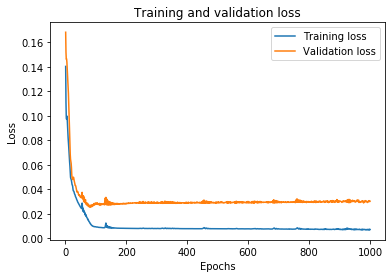

In [13]:
history_dict = history_256.history
history_dict.keys()
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

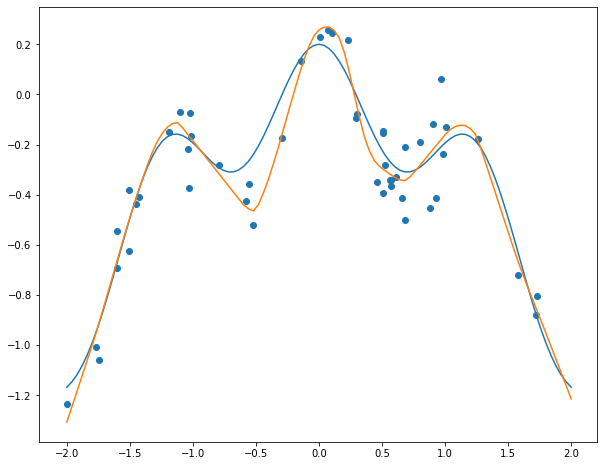

In [14]:
hidden_units = [256, 256, 256, 256, 256]
np.random.seed(65392)
b_init_seeds = np.random.randint(1, 1e6, size = len(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = len(hidden_units)+1)
model_256_less_train = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds, num_epochs = 100)
plot_layers(model_256_less_train, hidden_legend=False, include_hidden = False)

This works, but note that:
 * early stopping is almost equivalent to $L_2$ regularization (not obvious - proved using multivariate Taylor series, maybe we'll do this later)
 * early stopping can be a little risky; the right stopping point might be quite different with different initial parameter values.  This affects $L_2$ regularization less.

For these reasons, in general I recommend training until convergence and using another idea for regularization -- but this is good to know about and is also a partial motivation for dropout below.

### Idea 3: Combine predictions from multiple models (build an ensemble)

Fitting a bunch of models and averaging their predictions is **always** a good idea:

 * This can reduce some of the variability from random initializations.
 * If you use different model structures, can get some of the benefits from each model structure.
 * Essentially always yields a fairly small improvement in overall performance.  Ensembles win competitions where a small gain in performance matters, but is not always done in production models in companies.

See Stat 340 and/or machine learning in CS for more theoretical discussion in terms of variance reduction.

In [0]:
hidden_units = [256, 256, 256, 256, 256]
np.random.seed(65392)

model_fits = []

for i in range(10):
  b_init_seeds = np.random.randint(1, 1e6, size = len(hidden_units)+1)
  w_init_seeds = np.random.randint(1, 1e6, size = len(hidden_units)+1)
  model_fits.append(fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds, num_epochs = 100))

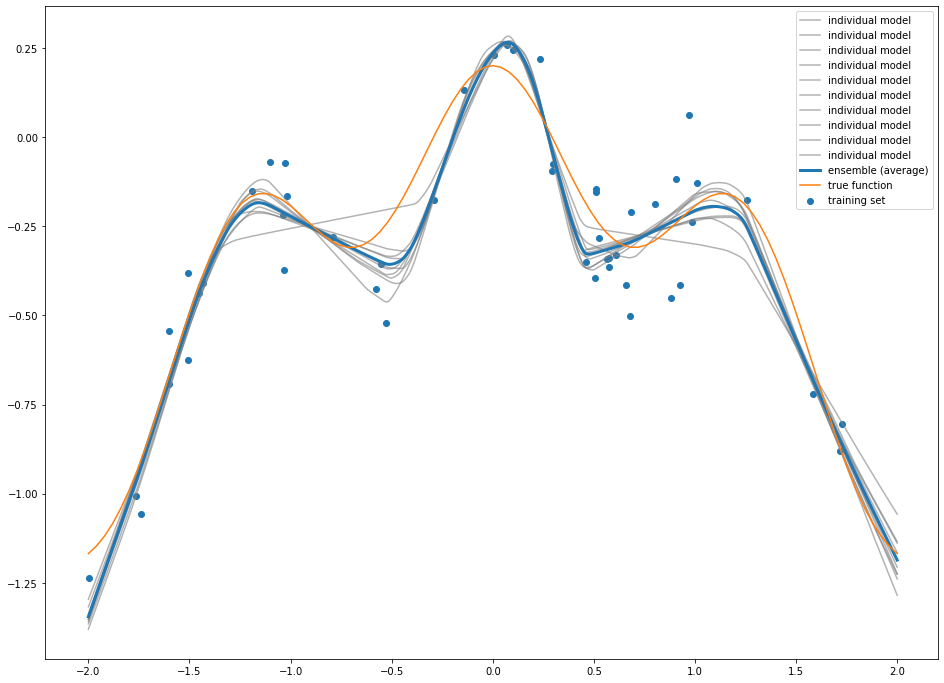

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

plot_x_grid = np.linspace(-2, 2, 401)

preds = np.zeros((10, 401))
for i in range(10):
  preds[i, :] = model_fits[i].predict(plot_x_grid.T)[:, 0]
  ax.plot(plot_x_grid, preds[i, :], c="gray", alpha = 0.6, label = "individual model")

ax.plot(plot_x_grid, np.mean(preds, axis = 0), linewidth = 3, label = "ensemble (average)")
ax.plot(x_grid[0, :], true_f, label = "true function")
ax.scatter(train_x[:, 0], train_y[:, 0], label = "training set")
plt.legend()

### Train and validation set performance of all four approaches
Here for the score labelled 'model_256_less_train' I have taken the average MSE across all the models we fit above with 256 units per layer and 500 epochs of training.

In [20]:
model_names = ['model_somany', 'model_256', 'model_256_less_train', 'ensemble']

train_val_scores = pd.DataFrame(index = model_names, columns = ['train_mse', 'val_mse'])

for model_name in model_names[0:3]:
  model = globals()[model_name]
  train_val_scores.loc[model_name, 'train_mse'] = model.evaluate(train_x, train_y)
  train_val_scores.loc[model_name, 'val_mse'] = model.evaluate(val_x, val_y)

train_preds = np.zeros((10, train_x.shape[0]))
val_preds = np.zeros((10, val_x.shape[0]))
component_train_mse = []
component_val_mse = []

for i in range(10):
  train_preds[i, :] = model_fits[i].predict(train_x)[:, 0]
  component_train_mse.append(np.mean((train_preds[i, :] - train_y[:,0])**2))
  val_preds[i, :] = model_fits[i].predict(val_x)[:, 0]
  component_val_mse.append(np.mean((val_preds[i, :] - val_y[:,0])**2))

ensemble_train_preds = np.mean(train_preds, axis = 0)
ensemble_val_preds = np.mean(val_preds, axis = 0)

train_val_scores.loc['model_256_less_train', 'train_mse'] = np.mean(component_train_mse)
train_val_scores.loc['model_256_less_train', 'val_mse'] = np.mean(component_val_mse)

train_val_scores.loc['ensemble', 'train_mse'] = np.mean((ensemble_train_preds - train_y[:,0])**2)
train_val_scores.loc['ensemble', 'val_mse'] = np.mean((ensemble_val_preds - val_y[:,0])**2)

train_val_scores

10000/10000 [==============================] - 0s 43us/step


,train_mse,val_mse
model_somany,0.00626838,0.0313612
model_256,0.00697594,0.0302323
model_256_less_train,0.0113222,0.0279638
ensemble,0.0105538,0.0270576


## Dropout

Dropout can be viewed as combining the above ideas.  Here's how it works:

 * Specify your big model:

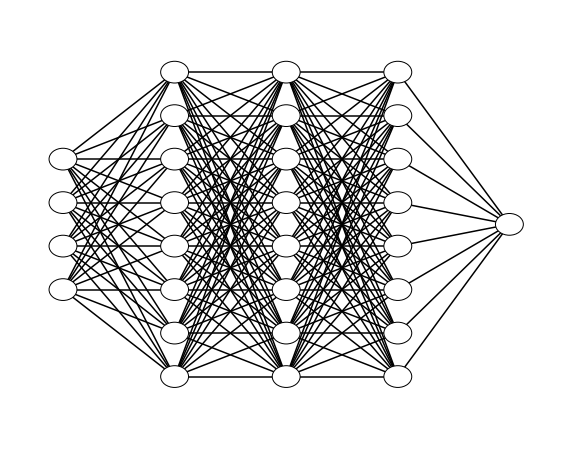

In [69]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
ax.axis('off')

layer_sizes = [4, 8, 8, 8, 1]
dropout_units=[[], [], [], [], []]
draw_neural_net(ax, .1, .9, .1, .9, layer_sizes=layer_sizes, dropout_units=dropout_units)


 * On each step of gradient descent, **randomly** select a subset of units in each hidden or input layer to "drop out" of the network.
    * Effectively, the activations for these units are set to 0.
    * These units make no contribution to the prediction or to the gradients for this step of gradient descent.
    * This means we are effectively fitting a smaller neural network for this iteration.
 * The **dropout rate** (between 0 and 1) is the probability that each unit is dropped out.
    * On average, this proportion of units will be dropped out in each layer -- could be more or less on any given sample.

In [95]:
dropout_rate = 0.5
np.random.seed(964)
print("sample 1: " + str(np.random.binomial(n = 1, p = dropout_rate, size = (4, 1))))
print("sample 2: " + str(np.random.binomial(n = 1, p = dropout_rate, size = (4, 1))))
print("sample 3: " + str(np.random.binomial(n = 1, p = dropout_rate, size = (4, 1))))

sample 1: [[1]
 [0]
 [1]
 [0]]
sample 2: [[0]
 [1]
 [0]
 [0]]
sample 3: [[1]
 [0]
 [0]
 [1]]


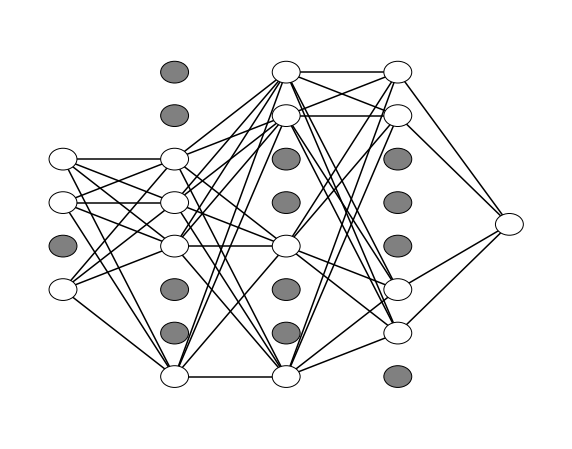

In [96]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
ax.axis('off')

# the sample_dropout function below is not generally available; it's specific
# to setting up for my the plot here.
dropout_units = sample_dropout(layer_sizes, dropout_rate)

draw_neural_net(ax, .1, .9, .1, .9, layer_sizes=layer_sizes, dropout_units=dropout_units)


 * On successive steps of gradient descent, we choose a different random subset of units to drop out.



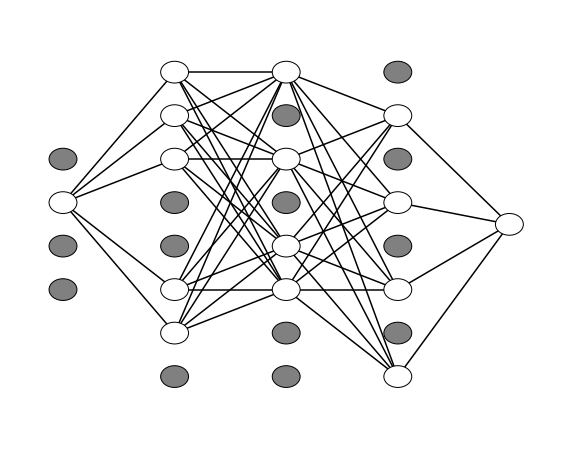

In [97]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
ax.axis('off')

# the sample_dropout function below is not generally available; it's specific
# to setting up for my the plot here.
dropout_units = sample_dropout(layer_sizes, dropout_rate)

draw_neural_net(ax, .1, .9, .1, .9, layer_sizes=layer_sizes, dropout_units=dropout_units)

 * When making predictions for a validation or test set, scale down the activations from each unit by **multiplying by the dropout rate when making test set predictions**.
    * Suppose dropout rate is 0.5.
    * On average, each unit is present only half the time during training.
    * On average, its contribution during forward propagation is 0.5 times its activation output.
 * Equivalently, make no adjustment during test phase and scale up activations by **dividing by the dropout rate during training**
    * With no adjustment, each unit would contribute only 0.5 times its activation output on average.
    * If we multiply by 2 (divide by 0.5) each unit contributes its activation output on average.


Why does dropout work?
 * This is similar to building an **ensemble** because it's like we're fitting a bunch of different models (each gradient descent step is effectively working with a different model) and then combining them.
 * This is similar to using a **reduced model size** because each gradient descent step only looks at/is able to use a subset of units.  As far as optimization is concerned, on any given step there is less model flexibility available
 * This is similar to using **early stopping** because no one of the smaller networks is trained fully to convergence.  Each smaller model is only trained for one step of gradient descent, not 1000.

### Dropout in Keras

In [105]:
dropout_rate = 0.2

np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = 6)
w_init_seeds = np.random.randint(1, 1e6, size = 6)

dropout_model = models.Sequential()

# you could add dropout on inputs but that doesn't make sense with only 1 x
#dropout_model.add(layers.Dropout(rate = dropout_rate))

# add hidden layers
b_initializer = initializers.RandomNormal(seed=b_init_seeds[0])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[0])
dropout_model.add(layers.Dense(1024,
    activation = 'relu',
    input_shape = (1,),
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

dropout_model.add(layers.Dropout(rate = dropout_rate))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[1])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[1])
dropout_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

dropout_model.add(layers.Dropout(rate = dropout_rate))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[2])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[2])
dropout_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

dropout_model.add(layers.Dropout(rate = dropout_rate))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[3])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[3])
dropout_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

dropout_model.add(layers.Dropout(rate = dropout_rate))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[4])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[4])
dropout_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

# add output layer
b_initializer = initializers.RandomNormal(seed=b_init_seeds[5])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[5])
dropout_model.add(layers.Dense(1,
    activation = 'linear',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

# compile and fit model
dropout_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])

dropout_model.fit(train_x, train_y,
  epochs = 1000,
  batch_size = train_x.shape[0],
  verbose = 0)

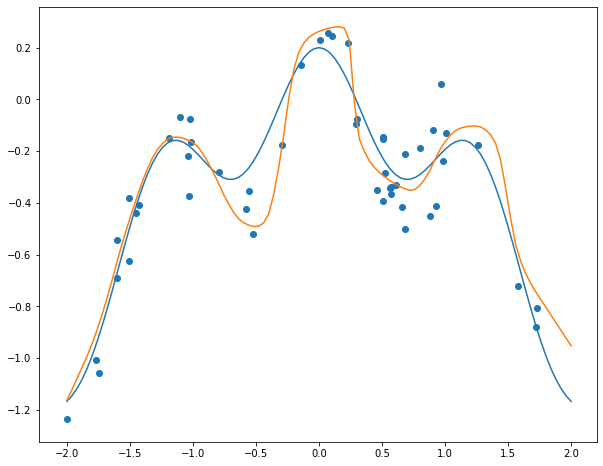

50/50 [==============================] - 1s 15ms/step
[0.010358586870133878, 0.010358586870133878]
10000/10000 [==============================] - 1s 55us/step
[0.03549703559279442, 0.03549703559279442]


In [106]:
plot_layers(dropout_model, hidden_legend=False, include_hidden = False)
print(dropout_model.evaluate(train_x, train_y))
print(dropout_model.evaluate(val_x, val_y))

This looks ok but doesn't have the best training or validation set performance.  The estimate is above the data in a few places; this is because of the scaling adjustment.

In [110]:
dropout_rate = 0.05

np.random.seed(8746)
b_init_seeds = np.random.randint(1, 1e6, size = 6)
w_init_seeds = np.random.randint(1, 1e6, size = 6)

dropout_model = models.Sequential()

# you could add dropout on inputs but that doesn't make sense with only 1 x
#dropout_model.add(layers.Dropout(rate = dropout_rate))

# add hidden layers
b_initializer = initializers.RandomNormal(seed=b_init_seeds[0])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[0])
dropout_model.add(layers.Dense(1024,
    activation = 'relu',
    input_shape = (1,),
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

dropout_model.add(layers.Dropout(rate = dropout_rate))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[1])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[1])
dropout_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

dropout_model.add(layers.Dropout(rate = dropout_rate))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[2])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[2])
dropout_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

dropout_model.add(layers.Dropout(rate = dropout_rate))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[3])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[3])
dropout_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

dropout_model.add(layers.Dropout(rate = dropout_rate))

b_initializer = initializers.RandomNormal(seed=b_init_seeds[4])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[4])
dropout_model.add(layers.Dense(1024,
    activation = 'relu',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

# add output layer
b_initializer = initializers.RandomNormal(seed=b_init_seeds[5])
w_initializer = initializers.RandomNormal(seed=w_init_seeds[5])
dropout_model.add(layers.Dense(1,
    activation = 'linear',
    bias_initializer = b_initializer,
    kernel_initializer = w_initializer))

# compile and fit model
dropout_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])

dropout_model.fit(train_x, train_y,
  epochs = 1000,
  batch_size = train_x.shape[0],
  verbose = 0)

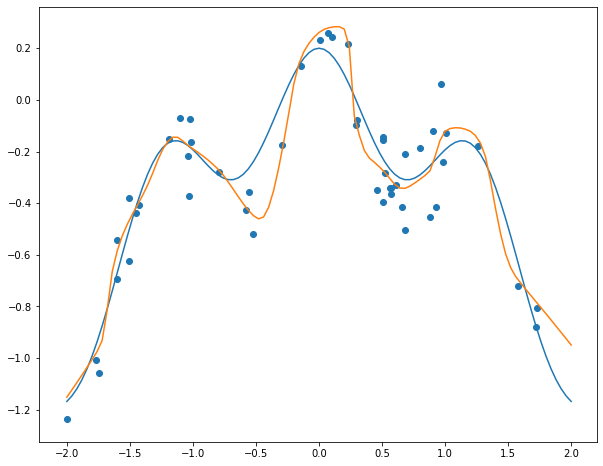

50/50 [==============================] - 1s 17ms/step
[0.008277178294956684, 0.008277178294956684]
10000/10000 [==============================] - 1s 54us/step
[0.032732396107912065, 0.032732396107912065]


In [111]:
plot_layers(dropout_model, hidden_legend=False, include_hidden = False)
print(dropout_model.evaluate(train_x, train_y))
print(dropout_model.evaluate(val_x, val_y))

# Exploding and Vanishing Gradients

## Observation: neural network performance can go down as you add more layers (for reasons other than overfitting)

### 13 layers of 32 units each

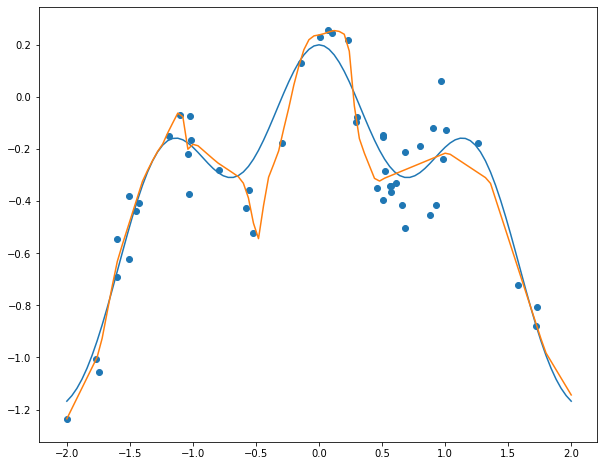

In [24]:
hidden_units = [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
np.random.seed(3575)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_13layers = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_13layers, hidden_legend=False, include_hidden = False)

This model has slightly overfit the training data, but it's not too bad.

### 14 layers of 32 units each

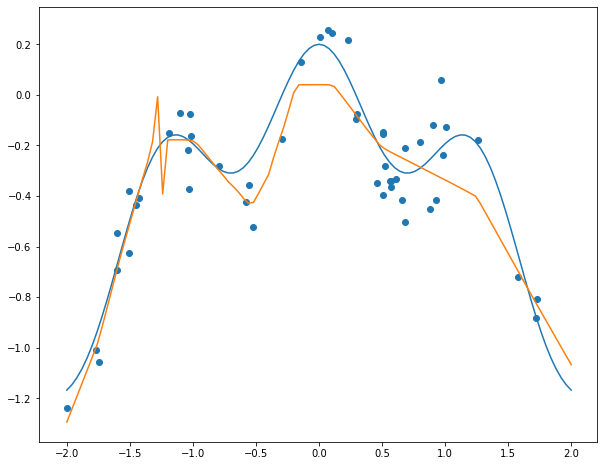

In [22]:
hidden_units = [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
np.random.seed(3575)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_14layers = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_14layers, hidden_legend=False, include_hidden = False)

This model definitely looks worse than the model with 13 layers.

Note that the model does not look worse because it has overfit the data:

 * There are spikes, but they don't correspond to training set data.
 * Near 0 the estimated function is below the training data.  This is not what we'd see if we were overfitting.

### 15 layers of 32 units each

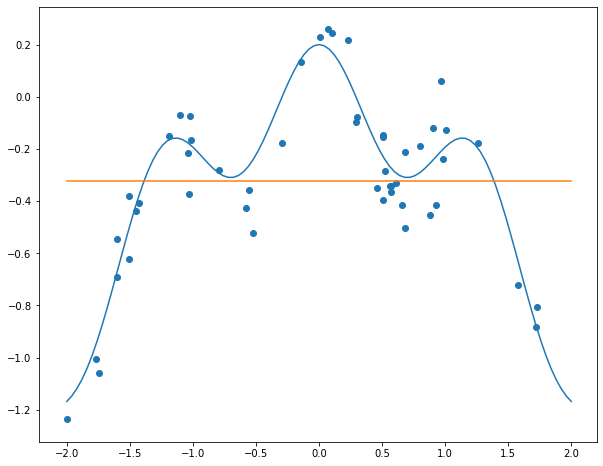

In [23]:
hidden_units = [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
np.random.seed(3575)
b_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
w_init_seeds = np.random.randint(1, 1e6, size = sum(hidden_units)+1)
model_15layers = fit_model_ex1(hidden_units, b_init_seeds, w_init_seeds)
plot_layers(model_15layers, hidden_legend=False, include_hidden = False)

Estimation has totally failed.  Why?

Let's inspect the gradients for the weight parameters.

Here's a summary of our model:

In [36]:
model_15layers.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_164 (Dense)            (None, 32)                64        
_________________________________________________________________
dense_165 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_166 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_167 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_168 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_169 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_170 (Dense)            (None, 32)              

In [44]:
import tensorflow as tf

# code here adapted from
# https://stackoverflow.com/questions/39561560/getting-gradient-of-model-output-w-r-t-weights-using-keras

# object representing the output a for our model.
output_tensor = model_15layers.output

# list of objects representing weights 
weight_tensors = model_15layers.trainable_weights
weight_tensors = weight_tensors[0:len(weight_tensors):2]

# calculate gradient of J with respect to weights, for each layer's weights
gradients = k.gradients(output_tensor, weight_tensors)
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
w_gradients_by_layer = sess.run(gradients, feed_dict = { model_15layers.input:train_x })
sess.close()

weight_tensors:
[<tf.Variable 'dense_164/kernel:0' shape=(1, 32) dtype=float32_ref>, <tf.Variable 'dense_165/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dense_166/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dense_167/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dense_168/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dense_169/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dense_170/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dense_171/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dense_172/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dense_173/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dense_174/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dense_175/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dense_176/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dense_177/kernel:0' shape=(32, 32) dtype=float32_ref>, <tf.Variable 'dens

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [45]:
w_gradients_by_layer

[array([[-5.1128570e-11,  1.4558806e-11,  8.8109138e-12,  1.0374611e-11,
          0.0000000e+00, -4.1665487e-11,  2.3008637e-11,  1.4040640e-11,
          0.0000000e+00,  2.9587180e-11,  1.2040632e-11,  3.5399409e-11,
          8.6199811e-11,  6.9892765e-11,  3.9537221e-11, -3.5880274e-11,
          1.7834813e-11,  2.4683039e-11,  3.5862643e-11, -2.6082041e-11,
          0.0000000e+00,  0.0000000e+00,  1.9786824e-12, -3.0482141e-11,
          0.0000000e+00,  2.4237433e-11,  4.3163390e-11,  0.0000000e+00,
         -1.2263329e-11,  0.0000000e+00, -4.7673445e-12, -5.4395251e-12]],
       dtype=float32),
 array([[ 1.8212415e-13,  4.1658879e-14, -1.1628683e-12, ...,
          2.0910598e-13,  0.0000000e+00,  0.0000000e+00],
        [ 8.2808630e-12,  0.0000000e+00, -6.6680841e-11, ...,
          0.0000000e+00,  8.6835504e-16,  0.0000000e+00],
        [ 3.0822716e-13,  0.0000000e+00, -2.7909812e-12, ...,
          0.0000000e+00,  1.5795109e-16,  0.0000000e+00],
        ...,
        [ 0.000000

In [46]:
[np.max(w_grad_one_layer) for w_grad_one_layer in w_gradients_by_layer]

[8.619981e-11,
 7.4668494e-11,
 5.555045e-10,
 1.1582649e-09,
 1.0108434e-08,
 7.581418e-08,
 3.8226204e-07,
 3.2883786e-06,
 2.7240822e-05,
 0.00021533686,
 0.0004904665,
 0.004181428,
 0.02815935,
 0.1306683,
 0.8350754,
 5.0867157]

By the time we get to the first layer, the gradients are essentially 0 and provide no information about how to update the weights to achieve a better model fit.